<h1 style="letter-spacing:0px;">Skin Fork</h1>

Esse é o nome-codigo de um engine criado utilizando o Ursina.

Este NB contem codigo removido do projeto, tentativa que nao seguiu com relação a desenhar bacias hidrograficas.

No entanto o codigo que executava transformada discreta de Fourier é funcional e vou preserva-lo aqui.


<h1>Fourier Gerador de rios (e arvores)</h1>

O conceito é criar um algoritmo de desenho baseado na transformação de Fourier. Um conjunto de dados que represente um rio deve ser transformado.

Um rio tipico entao (componentes x e y do path formado pelo rio) deve ser analisado e convertidos em epiciclos.

Normalmente a transformação desenharia exatamente sempre o mesmo rio, entao deve-se desenvolver um algoritmo que perturbe os valores (adicione/subtraia pequenos valores nos componentes do epiciclo calculado). As perturbações podem ser aleatorioas, mas as medias das transformações devem ser zero, ou corre-se o risco de desenhar-se coisas muito diversas do que o rio original.

Para gerar os afluentes, deve-se desenhar o rio como um conjunto de varios paths identicos e paralelos, mas um evento faz com que um "braço" (um conjunto dessas linhas) assuma um angulo com as originais. A partir dai as perturbações no desenho desse ramo devem ser diferentes daquelas anteriores da linha original do rio principal.

O processo é repetido até que cada uma das linhas esteja isolada (correndo sozinha com seus conjuntos de perturbações). Nesse ponto cada uma deve seguir mais um pouco (um valor aleatorio tb) e encerrar.

Quando todas as linhas encerrarem, teremos finalizado o desenho do rio.

O mesmo algoritmo pode ser usado pra criar meshes de arvores. Um tronco composto de um conjunto de cilindros vai sendo deformado enquanto "se move" do chao em direção vertical para cima, e um evento faz com que um desses cilidros assuma um angulo com o tronco (será um galho) da mesma forma que foi feito com os afluentes do rio. A diferença é que esse processo deve ser 3D, enquanto a geração de rio + bacia de drenagem é 2D.

Outra coisa que pode-se tentar fazer com Fourier é desenhar curvas de nivel. Cria-se uma grid de quadrados com alturas, agrupam-se os com as mesmas alturas, e transformam-se os conjuntos nos vertices externos (hull). Faz-se a transformação de Fourier com uma quantidade pequena de componentes e faz-se o desenho, que em tese será entao uma curva de nivel.

In [2]:
!pip install matplotlib
!pip install shapely

     |████████████████████████████████| 10.3 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 72.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 59.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 4.5 MB/s eta 0:00:01


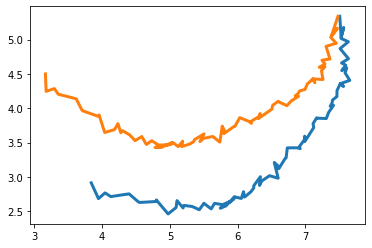

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
import random

def river_bed( num_of_points ):
    
    r1 = list( zip( range( 1, 10 ), range( 1, 10 )))
    r2 = [( 9.2, 8.3 ), ( 9, 7.5 ), ( 8, 6.5 ), ( 7, 5.5 ), ( 6, 4.5 ), ( 5.2, 3.6 ), ( 4, 2.5 )]
    r2 += [( 3, 1.7 ), ( 2, 1 ), ( 1, 1 )]
    r1 = np.array( r1 + r2 )
    xs, ys = r1[:,0], r1[:,1]


    def interpolate( inp, fi ):
        i, f = int( fi // 1 ), fi % 1  # Split floating-point index into whole & fractional parts.
        j = i + 1 if f > 0 else i  # Avoid index error.
        return ( 1 - f ) * inp[ i ] + f * inp[ j ]

    nlen = num_of_points * 2
    delta = ( len( r1 ) - 1 ) / ( nlen - 1 )

    xs = [ interpolate( xs, i * delta ) for i in range( nlen )]
    ys = [ interpolate( ys, i * delta ) for i in range( nlen )]

    r1 = tuple( zip( xs, ys ))

    river = np.array([ complex( float( r[ 0 ]), float( r[ 1 ])) for r in r1 ])

    N = float(len( river ))

    # discrete fourier transform
    fft = [ sum([ pt_cpx * cmath.exp( -2 * math.pi * 1j * float( k ) * float( ord ) / N )
                for ord, pt_cpx in enumerate ( river )])
                    for k in range( len( river ))]

    fftr = [ cpx.real for cpx in fft ]
    ffti = [ cpx.imag for cpx in fft ]

    # epicycles
    # freq (k cycles per N samples), amp, phase
    itf = 3. / nlen
    epi = np.array([( k + random.random() * itf, np.abs( cpx ) / N + random.random() * itf, 
                math.atan2( cpx.imag, cpx.real ) + random.random() * itf ) for k, cpx in enumerate( fft )])

    freq, amp, phase = 0, 1, 2
    tilt = 1 if random.random() > 0.5 else 0
    pts = np.array([[( math.cos( math.pi * 2. / nlen * float( t ) * epi[ k ][ freq ] + epi[ k ][ phase ]) * epi[ k ][ amp ],
              math.sin( math.pi * 2. / nlen * float( t ) * epi[ k ][ freq ] + epi[ k ][ phase ]) * epi[ k ][ amp ])
                 for t in range( int( nlen * 0.40 ))]
                 for k in range( int( random.random() * 5.) * tilt, int( nlen - int( random.random() * 5.) * ( 1 - tilt )))])

    final = np.sum( pts, -3 )
    return final

# river
rbed = river_bed( 101 )

def rotate( x, y, radians, origin=(0, 0)):
    """Rotate a matrix around a given point."""
    
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy


#xs = np.hstack(( rbed[:,0][1:-1], ( rbed[:,0][1:-1] + 0.025 )[::-1 ], ( rbed[:,0][1:-1] - 0.025 )))  
#ys = np.hstack(( rbed[:,1][1:-1], ( rbed[:,1][1:-1] + 0.025 )[::-1 ], ( rbed[:,1][1:-1] - 0.025 )))

xs, ys = rotate( rbed[:,0][1:-1], rbed[:,1][1:-1], math.pi / 8., rbed[-1] )
plt.plot( rbed[:,0][1:-1], rbed[:,1][1:-1], linewidth=3 )
plt.plot( xs, ys, linewidth=3 )
plt.show()

Embora o resultado acima seja interessante, nao gostei de nenhuma das formas que tentei de evoluir o conceito de um rio simples para uma bacia hidrografica. Vou mudar a abordagem e fazer uma analise hidrografica real:

- cercar uma area aproximadamente triangular e escolhar o local de descarga 
    (normalmente na altura zero num corpo de agua, num vertice do triangulo)
- escolher um numero de afluentes maximose encontrar maximos locais de altura pra eles
    (utilizando "ascendente de gradiente" :) )
- criar automatos celulares q irao descer, procurando outros no caminho e indo na direcao da descarga
- o process de descida tera q ser ponderado por outro, q pode ser pensado como dificuldade do terreno
- ao descer, o automato vai ficar no ponto mais baixo, mas no terreno mais facil (e dessa forma cavar
    terrenos mais faceis q estiverem mais altos)
- se ele tivesse q ser forçado a subir, permanece no mesmo nivel e cava os terrenos na direção q tem q 
    seguir
- os automatos, ao serem desviados da direcao q querem ir, vao acumulando um valor q aumenta a probabilidade
    deles voltarem para a direcao q querem seguir, e qdo isso ocorre eles retomam a direcao mesmo q tenham
    q cavar

Uma vez completado o algoritmo acima, que desenha o path original do rio, o proximo passo é completar o que desenha a bacia de drenagem. Serão os seguintes passos, de forma mais especifica do que na descrição acima:

- cria o path original do do rio
- registra num original de divisoes de 9 a 16
- registra prop original de tamanho de 10% a 80%
- registra o num de vxs original * 80% (lim sup prop tamanho)
- coloca o rio principal na lista de paths a subdividir
- executa 3 vezes:
    - para cada path a subdividir:
        - sorteia divisoes. Se for 1 ou menos, nao subdivide esse branch.<br/>
            subdivs ficam entre num min e max, mas num maximo é ajustado pela proporção<br/> 
             maxima de tamanho
        - divide um intervalo de 0..1 aleatoriamente no num de divs
        - calcula os pontos em q a divisao ocorre usando esse intervalo
        - para cada div:
            - cria um branch (novo rio) com um tamanho sorteado dentro da faixa
            - escolhe um lado e rotaciona o branch um angulo aleatorio
            - rotaciona e posiciona o branch
            - verifica se o branch cruza algum outro
                - sim: tenta rotacionar ate que ele nao cruze
                - se for impossivel, remova o branch
            - anota o branch na lista de paths futura
    - tira a raiz do limite de divisoes para o prox ciclo e arredonda os valores
    - aumente o lim inferior de tamanho em 5% e reduz o superior em 10%
    - multiplica o num de vertices pelo lim superior de tamanho
    - assume a lista futura de paths

  

divs 18
divs 12
divs 15
divs 13
divs 11
divs 10
divs 10
divs 9
divs 7
divs 8


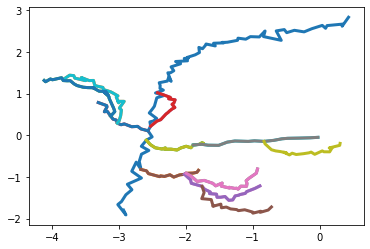

In [110]:
import random
import math
from math import sqrt
import matplotlib.pyplot as plt
from shapely.geometry import LineString


def rotate( x, y, radians, origin=(0, 0)):
    """Rotate a matrix around a given point."""
    
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy

    

# first vx for some reason is very far from the 2nd
numpts = 99
rmain = river_bed( numpts + 1 )[1:-1]

sizepr = [ 0.1, 0.6 ]    # starting size proportion between branch and parent
divlim = [ 16., 25.]     # starting limits to subdivid river branches
vxs = float( numpts )    # max num of vxs that shoul appear in the next iteration
paths = [ rmain ]
lpaths = [ LineString( rmain )]
cursor = 0  # points to the first branch that need to be divided


for i in range( 3 ):
    # for each branch to subdiv
    lim = len( paths )
    added = 0
    
    #print( "dividing " + str(( lim - cursor )) + " branches" )
    #print( "there are(is) " + str( len( paths )) + " at the moment" )
    #print( "scanning from path " + str( cursor ) + " to the path " + str( lim ))
    
    for rnum in range( cursor, lim ):
        path = paths[ rnum ]
        
        lpath = lpaths[ rnum ]
        plt.plot( *lpath.xy, linewidth=3 )

        maxdiv = divlim[ 1 ] # * sizepr[ 1 ]
        
        # random number of divs between limits
        divs = int( random.random() * ( maxdiv - divlim[ 0 ]) + divlim[ 0 ])
        print( "divs", divs )
        
        # size
        size = random.random() * ( sizepr[ 1 ] - sizepr[ 0 ]) + sizepr[ 0 ]
        
        # divide an 0..1 interval in div random slices
        nvxs = int(( vxs + 1. ) * size )
        span = [ int( random.random() * nvxs ) % nvxs for k in range( divs )]
        span.sort()

        for div in span:
            # anchor point
            if div >= len( path ):
                continue

            vx = path[ div ]
            
            # create new path
            subp = river_bed( int(( vxs + 1. ) * size ) )[1:-1]
            
            # shrink it to the current size limit
            subp *= size
            
            # angle that the branch forms, from 10o to 120o but with
            # 45 as the value with great probability
            ang = 120. - sqrt( random.random() * 6850. )
            if ang < 10: ang = 10.
            if random.random() > 0.5: ang *= -1.

            # place and rotate the branch
            subp[:,0] += vx[ 0 ] - subp[:,0][ 0 ]
            subp[:,1] += vx[ 1 ] - subp[:,1][ 0 ]

            subp = np.array( rotate( subp[:,0], subp[:,1], math.radians( ang ), subp[ 0 ] )).T
            lsubp = LineString( subp )

            # check if new branch intercepts others
            for i in range( 10, 90, 10 ):
                cross = False
                for lpath in lpaths[ 0:len( paths )]:
                    inter = np.array( lsubp.intersection( lpath ))
                    #print( "shape", inter.shape )

                    if len( inter.shape ) > 1:
                        cross = True
                        break
                    else:
                        if len( inter ) > 1:
                            cross = True
                            break
                        
                if cross:
                    #print( "crossing, rotating branch..." )
                    subp = np.array( rotate( subp[:,0], subp[:,1], 
                                        math.radians( 10. * -1. if ang < 0 else 1.), subp[ 0 ] )).T
                    lsubp = LineString( subp )
                else:
                    #print( inter )
                    paths.append( subp )
                    lpaths.append( LineString( lsubp ))
                    added += 1
                    
                    x,y = lsubp.xy
                    plt.plot( x, y, linewidth=3 )

                    #print( "added", added, "len paths", len( paths ))
                    break
                

            
    cursor = lim
    sizepr = [ sizepr[ 0 ] + 0.1, sizepr[ 1 ] - 0.2 ]    # starting size proportion between branch and parent
    divlim = [ divlim[ 0 ] * 0.66, divlim[ 1 ] * 0.66 ]   # starting limits to subdivid river branches

#print( len( paths ))
plt.show()
            
            
        


Uma vez completado o algoritmo acima, que desenha o path original do rio, o proximo passo é completar o que desenha a bacia de drenagem. Serão os seguintes passos, de forma mais especifica do que na descrição acima:

- cria o path original do do rio
- registra num original de divisoes de 9 a 16
- registra prop original de tamanho de 10% a 80%
- registra o num de vxs original * 80% (lim sup prop tamanho)
- coloca o rio principal na lista de paths a subdividir
- executa 3 vezes:
    - para cada path a subdividir:
        - sorteia divisoes. Se for 1 ou menos, nao subdivide esse branch.<br/>
            subdivs ficam entre num min e max, mas num maximo é ajustado pela proporção<br/> 
             maxima de tamanho
        - divide um intervalo de 0..1 aleatoriamente no num de divs
        - calcula os pontos em q a divisao ocorre usando esse intervalo
        - para cada div:
            - inicialmente replica o path original
            - cria um path novo
            - cria um path que vai do inicio do path original até a div, e dai em diante
                continua a partir do mesmo vx div no path novo
            - escala o pedaço novo
            - rotaciona o pedaço novo 

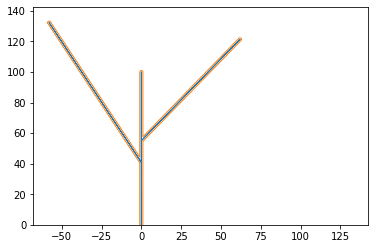

In [77]:
import random
import math
from math import sqrt
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import shapely
import numpy as np

pi = math.pi

# distance from the root to the stem
stem = 0.4
short = [ -0.4, 0, 0.3, 0.5 ]
prune = True # branches that would cross the tree are not added

path = LineString([(0,0), (0,100), (0,0)])


# build the tree-like structure
for i in range( 1 ):
    ncoords = []
    for sub in path.coords:
        # 30 % chance the path will not be forked
        if len( ncoords ) == 0 or random.random() < 0.33:
            ncoords.append( complex( *sub ))
        else:
            # next point
            subi = complex( *sub )
            previ = complex( ncoords[ -1 ])

            #direction vector 
            diri = subi - previ
            mag = np.abs( diri )
            
            #normalize
            diri /= mag
            stemh = stem + stem / 4. * random.random()
            fork = previ + diri * stemh * mag
            
            # distance to the end of the path + random term
            dt = np.abs( subi - fork ) * (1. + random.random() / 2. - short[ i ])
            
            # if we are in a path that takes us closer to the root, the angle of
            # forking must be negative
            dfk = np.abs( fork )
            dtr = np.abs( subi )
            ang = ( 40. if dtr > dfk else 130. ) + ( random.random() - 0.5 ) * 20.
            gem = diri * complex( math.cos( math.radians( ang )), math.sin( math.radians( ang )))
            gem *= dt
            
            ncoords.append( fork )
            ncoords.append( fork + gem )
            ncoords.append( fork )
            ncoords.append( subi )
            
    path = LineString([( round( cpx.real, 6 ), round( cpx.imag, 6 )) for cpx in ncoords ])
    
# remove all paths that are redundant
test = []
for i in range( 1, len( path.coords )):
    prev = path.coords[ i - 1 ]
    pt = path.coords[ i ]
    
    if prev == pt: continue

    sub = LineString([ prev, pt ])

    crossed = False
    for p in test:
        inter = type( sub.intersection( p ))
        if not inter is shapely.geometry.point.Point: crossed = True

    if len( test ) == 0:
        test.append( sub )
    else:
        if not crossed:
            test[ 0 ] = LineString([ *test[ 0 ].coords, *sub.coords ])
        else:
            test[ 0 ] = LineString([ *test[ 0 ].coords, sub.coords[ 1 ]])

path = test[ 0 ]

path = LineString( path )
x,y = path.xy
ax,ix = max(x), min(x)
ay,iy = max(y), min(y)

poly = path.buffer( 1 )
x,y = poly.exterior.coords.xy
plt.plot( *path.xy, linewidth=1 )
plt.plot( x, y, linewidth=1 )
plt.xlim([ min([ix, iy]) - 10, max([ax,ay]) + 10 ])
plt.ylim([0, max([ ax, ay ]) + 10 ])

#print( len( river ))
#for branch in river:
#    plt.plot( branch[:,0], branch[:,1], linewidth = 1 )
plt.show()